In [7]:
import pickle
from config_and_print import methy_directory, filtered_list, chrom_file, resolutions, output_directory, mappability_threshold, normalization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import os
import matplotlib.colors as mcolors

# Ensure resolutions is treated as a tuple or list of strings
if isinstance(resolutions, str):
    resolutions = (resolutions,)

# Print resolutions for debugging 
print(f"Resolutions from config: {resolutions}")

# Extract resolution value and label from the resolutions string
resolution_str = resolutions[0]

# Debug print to check the value of resolution_str
print(f"Extracted resolution string: {resolution_str}")

def parse_resolution(resolution_str):
    if ':' in resolution_str:
        resolution_value, resolution_label = resolution_str.split(':')
        try:
            resolution = int(resolution_value)
            return resolution, resolution_label
        except ValueError:
            raise ValueError(f"Resolution value should be an integer: '{resolution_value}' in '{resolution_str}'")
    else:
        raise ValueError(f"Invalid resolution format: '{resolution_str}'. Expected format 'value:label', e.g., '1000000:1Mb'.")

resolution, resolution_label = parse_resolution(resolution_str)

# Load original_bulk_data from the file
bulk_data_input_file = '../../projects/single_cell_files/nan_removed_bulk_data.pkl'
with open(bulk_data_input_file, 'rb') as f:
    bulk_data = pickle.load(f)
print(f"bulk_data loaded from {bulk_data_input_file}")

# Load original_bulk_data from the file
original_bulk_data_input_file = '../../projects/single_cell_files/original_bulk_data.pkl'
with open(original_bulk_data_input_file, 'rb') as f:
    original_bulk_data = pickle.load(f)
print(f"original_bulk_data loaded from {bulk_data_input_file}")

# Load chromosome_results from the file
chromosome_results_input_file = '../../projects/single_cell_files/chromosome_results.pkl'
with open(chromosome_results_input_file, 'rb') as f:
    chromosome_results = pickle.load(f)
print(f"chromosome_results loaded from {chromosome_results_input_file}")

########################################################################
#compute the genome-wide correlation of the two AB compartment cell types
# should be somehting like .6 if all the above steps were done correctly
# this is a sanity check
# There seems to be a problem here
# I beleive the issue is that without KR normalization, 
# the genome wide correlation of bulk is not that high
########################################################################
# Initialize lists to collect the eigenvector values for IMR90 and GM12878
imr90_values = []
gm12878_values = []

# Loop through each chromosome
for i in range(1, 23):
    key_gm12878 = f'res{resolution}_ch{i}_oe_GM12878_{normalization}_eigenvector'
    key_imr90 = f'res{resolution}_ch{i}_oe_IMR90_{normalization}_eigenvector'                                                               
                                                               
    # Check if the keys exist in the data to avoid KeyErrors
    if key_gm12878 in bulk_data and key_imr90 in bulk_data:
        # Extend the list with the eigenvector values from each chromosome
        # Ensure values are numeric (floats or ints)
        gm12878_vals = bulk_data[key_gm12878]['eigenvalue']
        imr90_vals = bulk_data[key_imr90]['eigenvalue']
        imr90_values.extend(imr90_vals)
        gm12878_values.extend(gm12878_vals)
        
# Convert lists to pandas Series for correlation calculation
imr90_series = pd.Series(imr90_values)
gm12878_series = pd.Series(gm12878_values)

# Calculate the Pearson correlation coefficient between IMR90 and GM12878
correlation = imr90_series.corr(gm12878_series)

print(f'Genome-wide correlation between IMR90 and GM12878: {correlation}')



Resolutions from config: ('1000000:1Mb',)
Extracted resolution string: 1000000:1Mb
bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data.pkl
original_bulk_data loaded from ../../projects/single_cell_files/nan_removed_bulk_data.pkl
chromosome_results loaded from ../../projects/single_cell_files/chromosome_results.pkl
Genome-wide correlation between IMR90 and GM12878: 0.6687364447778326


In [8]:
chromosome_results['chr11']

,Sample,A/B Compartment,Correlation With Bulk,Correlation With Other Bulk,Cell Type
0,sc11.ACTTGA,"[-0.001996260134358732, 0.0029843310069772146,...",0.017911,0.017911,gm12878
1,sc11.CGATGT,"[-0.002208453420919976, 0.003204905183222053, ...",0.089631,0.099183,imr90
2,sc11.GCCAAT,"[0.002464560099677278, -0.0017747919120559667,...",0.122899,0.115505,imr90
3,sc11.TAGCTT,"[-0.009971582108582061, -0.002887513219909002,...",0.037295,0.037295,gm12878
4,sc12.ACTTGA,"[-0.009988571147182502, -0.009985209305810186,...",0.028061,0.017026,imr90
...,...,...,...,...,...
124,sc8.ACTTGA,"[-0.0011801374463571383, -0.003539522543757835...",0.107674,0.016432,imr90
125,sc9.ACTTGA,"[0.004957549130336374, 0.003765320263677944, -...",0.050184,0.050184,gm12878
126,sc9.CGATGT,"[-0.009055192038077956, -0.0047701067079315915...",0.072359,0.037329,imr90
127,sc9.GCCAAT,"[-0.0003695266934496972, -0.004470923380794043...",0.119076,0.119076,gm12878


In [9]:
def calculate_average_correlations_from_precomputed(chromosome_results, chromosomes):
    gm12878_avg_correlations = {}
    imr90_avg_correlations = {}
    gm12878_avg_correlations_withIMR90 = {}
    imr90_avg_correlations_withGM12878 = {}
    
    for chr in chromosomes:
        # Access the specific chromosome data
        sc_dataframe = chromosome_results[f'chr{chr}']

        # Extract correlations for GM12878
        gm12878_correlations = sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['Correlation With Bulk']
        gm12878_avg_correlations[chr] = gm12878_correlations.mean()
        gm12878_correlations_withIMR90 = sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['Correlation With Other Bulk']
        gm12878_avg_correlations_withIMR90[chr] = gm12878_correlations_withIMR90.mean()
        
        # Extract correlations for IMR90
        imr90_correlations = sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['Correlation With Bulk']
        imr90_avg_correlations[chr] = imr90_correlations.mean()
        imr90_avg_correlations_withGM12878 = sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['Correlation With Other Bulk']
        imr90_avg_correlations_withGM12878[chr] = imr90_avg_correlations_withGM12878.mean()

    return gm12878_avg_correlations, imr90_avg_correlations, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878

# Example usage
chromosomes = [str(i) for i in range(1, 23)] 
gm12878_avg_corr, imr90_avg_corr, gm12878_avg_correlations_withIMR90, imr90_avg_correlations_withGM12878 = calculate_average_correlations_from_precomputed(chromosome_results, chromosomes)

# Print the results
print("Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:")
for chr in chromosomes:
    corr = gm12878_avg_corr.get(chr, np.nan)
    corr_other = gm12878_avg_correlations_withIMR90.get(chr, np.nan)
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")

print("\nAverage correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:")
for chr in chromosomes:
    corr = imr90_avg_corr.get(chr, np.nan)
    corr_other = imr90_avg_correlations_withGM12878.get(chr, np.nan)
    print(f"Chromosome {chr}: {corr:.4f}, {corr_other:.4f}")


Average correlations for GM12878 with bulk GM12878 and bulk IMR90 by chromosome:
Chromosome 1: 0.0700, 0.0700
Chromosome 2: 0.0646, 0.0646
Chromosome 3: 0.0810, 0.0810
Chromosome 4: 0.0654, 0.0654
Chromosome 5: 0.0942, 0.0942
Chromosome 6: 0.0749, 0.0749
Chromosome 7: 0.0752, 0.0752
Chromosome 8: 0.0741, 0.0741
Chromosome 9: 0.0965, 0.0965
Chromosome 10: 0.0880, 0.0880
Chromosome 11: 0.0812, 0.0812
Chromosome 12: 0.0809, 0.0809
Chromosome 13: 0.1220, 0.1220
Chromosome 14: 0.1043, 0.1043
Chromosome 15: 0.1871, 0.1871
Chromosome 16: 0.1141, 0.1141
Chromosome 17: 0.1089, 0.1089
Chromosome 18: 0.1112, 0.1112
Chromosome 19: 0.1236, 0.1236
Chromosome 20: 0.1301, 0.1301
Chromosome 21: 0.2080, 0.2080
Chromosome 22: 0.1421, 0.1421

Average correlations for IMR90 with bulk IMR90 and bulk GM12878 by chromosome:
Chromosome 1: 0.0617, nan
Chromosome 2: 0.0629, nan
Chromosome 3: 0.0678, nan
Chromosome 4: 0.0714, nan
Chromosome 5: 0.0678, nan
Chromosome 6: 0.0820, nan
Chromosome 7: 0.0763, nan
Chromo

/tmp/ipykernel_140390/4251229429.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imr90_avg_correlations_withGM12878[chr] = imr90_avg_correlations_withGM12878.mean()
/tmp/ipykernel_140390/4251229429.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imr90_avg_correlations_withGM12878[chr] = imr90_avg_correlations_withGM12878.mean()
/tmp/ipykernel_140390/4251229429.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imr90_avg_cor

In [10]:
chr = 1
chromosome_results[f'chr{chr}']

,Sample,A/B Compartment,Correlation With Bulk,Correlation With Other Bulk,Cell Type
0,sc11.ACTTGA,"[nan, 0.00999999999887582, 0.00999999999991210...",0.033589,0.033589,gm12878
1,sc11.CGATGT,"[nan, -0.00860145974174996, -0.008085117258960...",0.013052,-0.004874,imr90
2,sc11.GCCAAT,"[nan, 0.007224265287621554, 0.0021975034515107...",0.020947,0.041650,imr90
3,sc11.TAGCTT,"[nan, 0.00717223226846834, 0.0078593022772871,...",0.135427,0.135427,gm12878
4,sc12.ACTTGA,"[nan, -0.006025251715588904, -0.01, 0.00387379...",0.021850,0.045165,imr90
...,...,...,...,...,...
124,sc8.ACTTGA,"[nan, 0.004280592728428014, 0.0025654303469549...",0.069955,-0.113859,imr90
125,sc9.ACTTGA,"[nan, 0.0016417632617453867, 0.005036153409245...",0.007107,0.007107,gm12878
126,sc9.CGATGT,"[nan, -0.004515304166640753, 0.006761261958069...",0.019136,-0.047854,imr90
127,sc9.GCCAAT,"[nan, 0.01, -0.0006984483014165713, -0.0021366...",0.077734,0.077734,gm12878


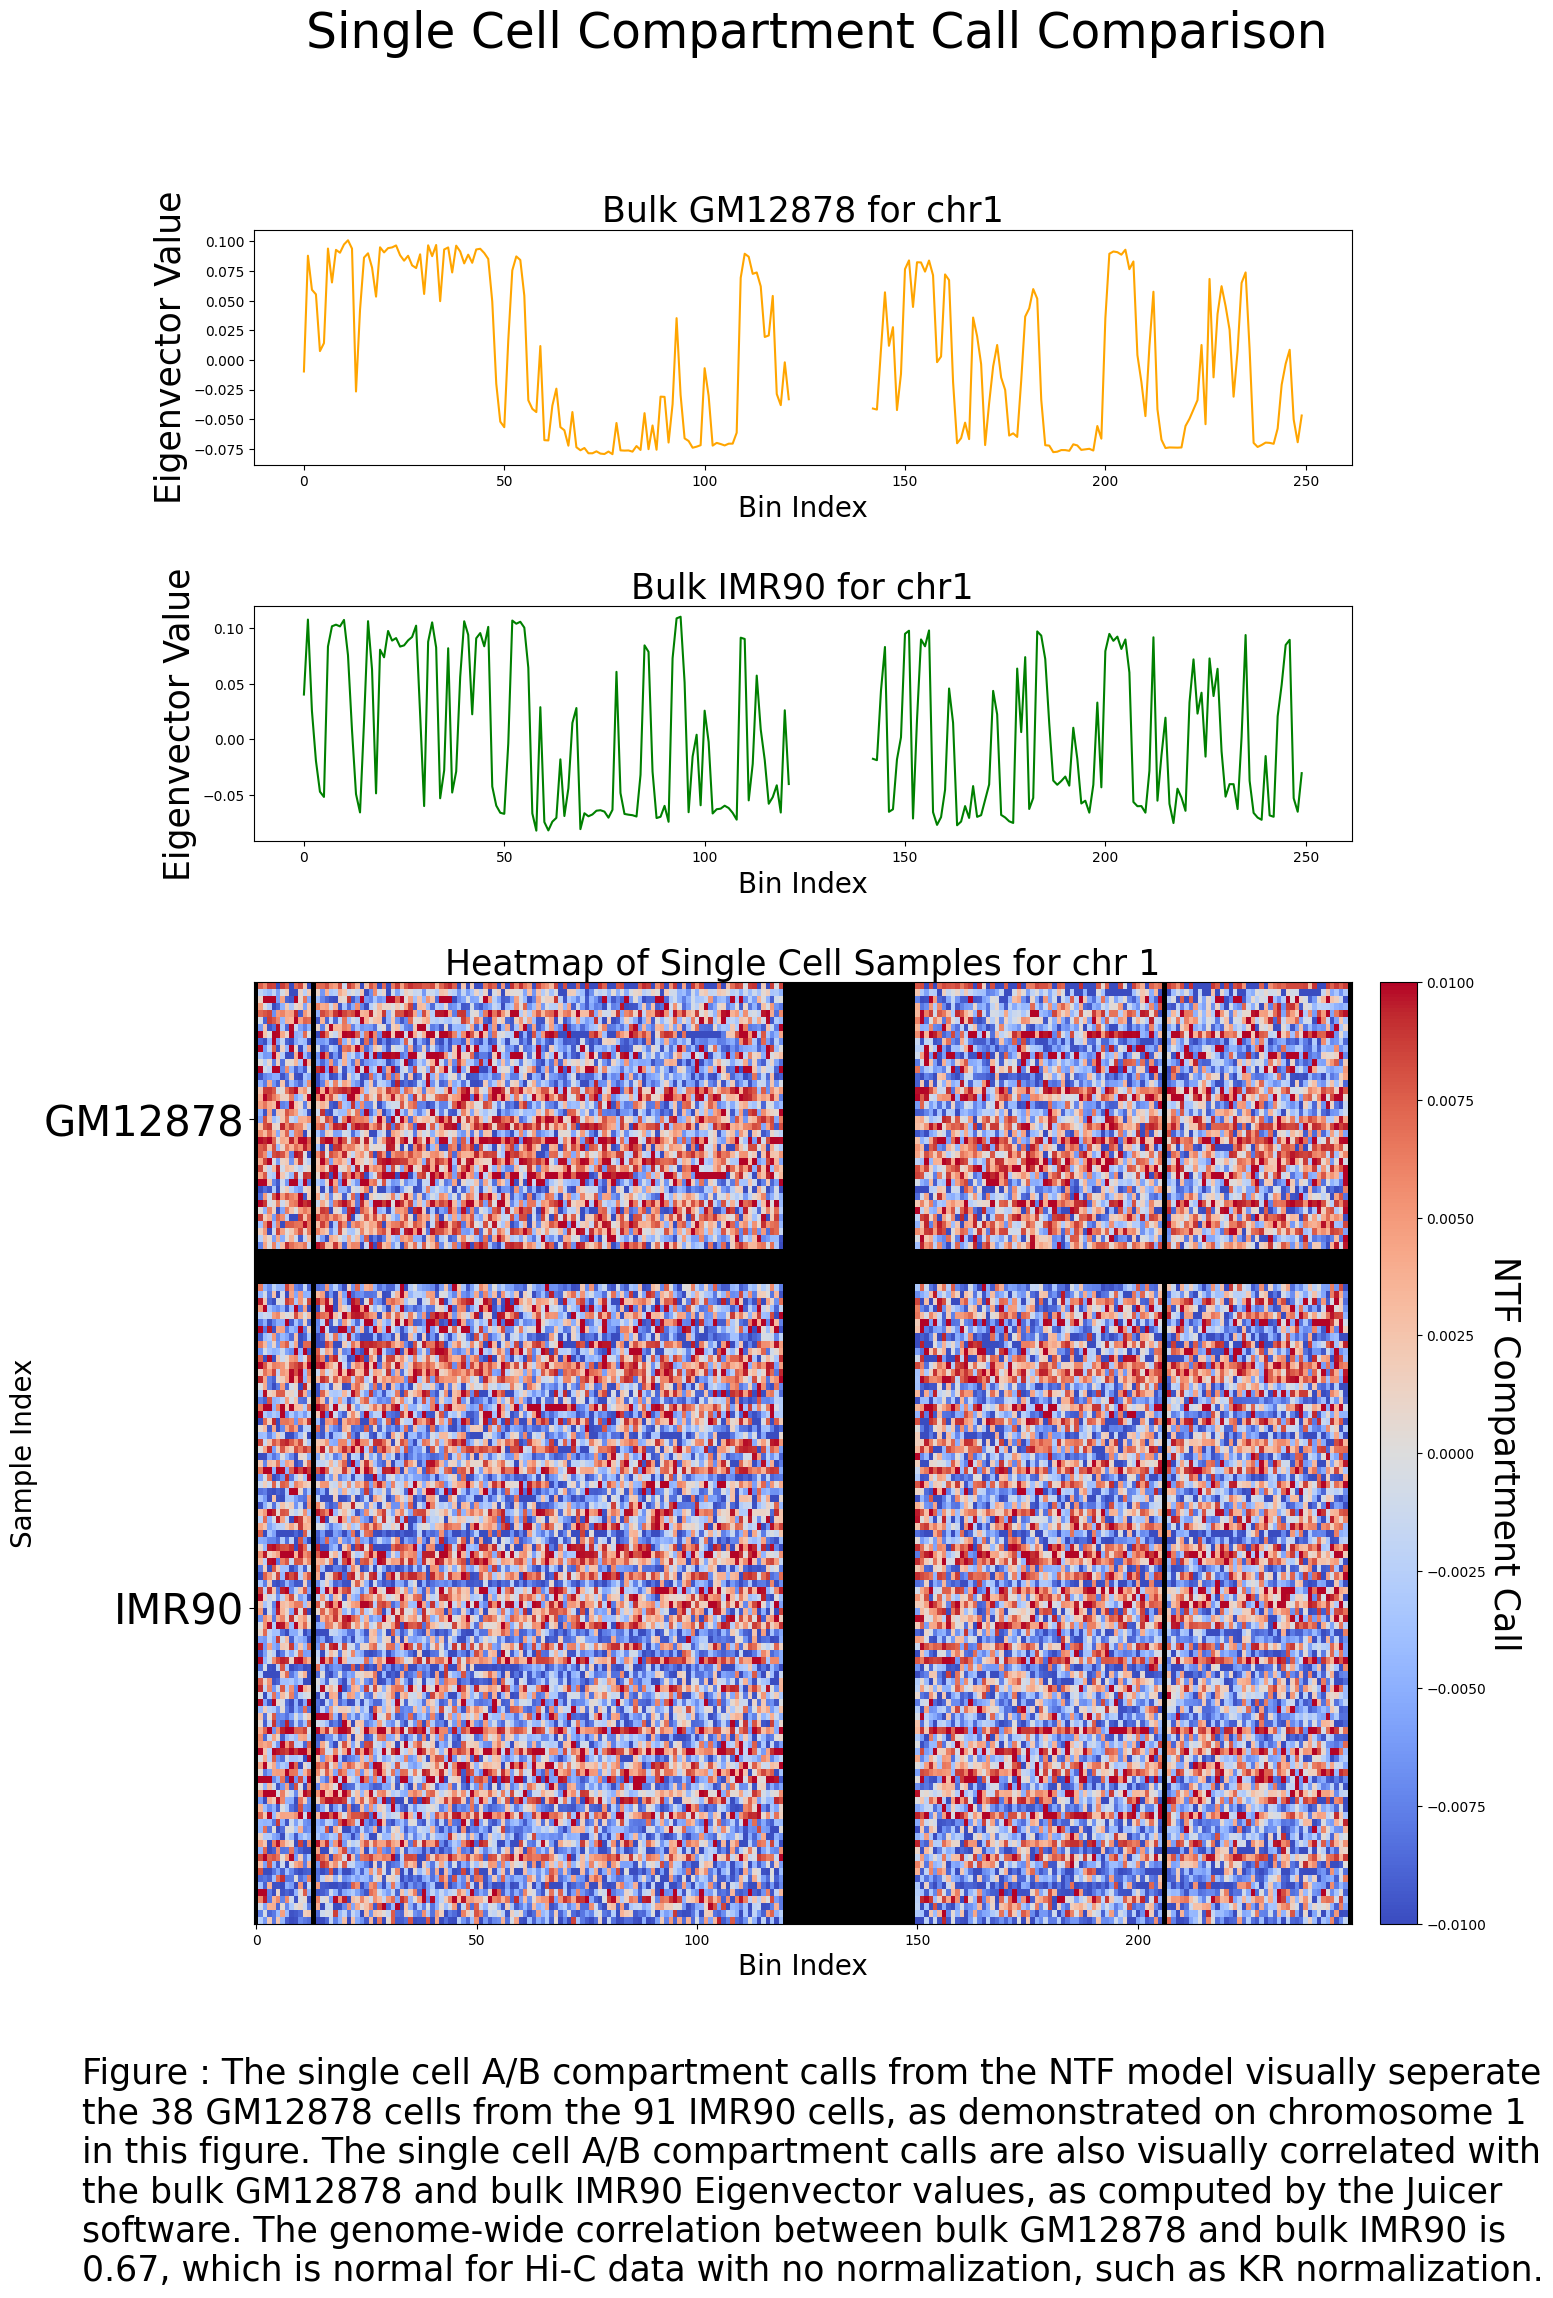

In [18]:
chr = 1
sc_dataframe = chromosome_results[f'chr{chr}']

# Define the bulk eigenvectors
bulk_eigenvector_gm12878 = original_bulk_data[f'res1000000_ch{chr}_oe_GM12878_{normalization}_eigenvector']['eigenvalue'].values
bulk_eigenvector_imr90 = original_bulk_data[f'res1000000_ch{chr}_oe_IMR90_{normalization}_eigenvector']['eigenvalue'].values

# Sort and prepare the dataframe
sc_dataframe['Cell Type Sort'] = sc_dataframe['Cell Type'].map({'gm12878': 0, 'imr90': 1})
sc_dataframe = sc_dataframe.sort_values(by=['Cell Type Sort', 'Correlation With Bulk'], ascending=[True, False])
sc_dataframe.drop('Cell Type Sort', axis=1, inplace=True)

def plot_eigenvectors_with_heatmap(bulk_eigenvector1, bulk_eigenvector2, sc_dataframe, title1, title2, title, correlation, chr, save_path=None, separation_rows=5):
    fig = plt.figure(figsize=(15, 22))  # Adjusted the figure size for better proportions
    gs = gridspec.GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[30, 1], height_ratios=[1, 1, 4], hspace=0.3, wspace=0.05)

    ax_bulk1 = fig.add_subplot(gs[0, 0])
    ax_bulk1.plot(bulk_eigenvector1, color='orange')
    ax_bulk1.set_title(title1, fontsize=25)
    ax_bulk1.set_xlabel("Bin Index", fontsize=20)
    ax_bulk1.set_ylabel("Eigenvector Value", fontsize=25)

    ax_bulk2 = fig.add_subplot(gs[1, 0])
    ax_bulk2.plot(bulk_eigenvector2, color='green')
    ax_bulk2.set_title(title2, fontsize=25)
    ax_bulk2.set_xlabel("Bin Index", fontsize=20)
    ax_bulk2.set_ylabel("Eigenvector Value", fontsize=25)

    gm12878_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'gm12878']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    imr90_data = np.stack(sc_dataframe[sc_dataframe['Cell Type'] == 'imr90']['A/B Compartment'].apply(lambda x: np.array(x)).tolist())
    
    empty_rows = np.full((separation_rows, gm12878_data.shape[1]), np.nan)
    sc_data_array = np.vstack([gm12878_data, empty_rows, imr90_data])

    # Create a colormap that does not include white for NaN values
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')  # Set NaN color to black

    ax_sc = fig.add_subplot(gs[2, 0])
    im = ax_sc.imshow(sc_data_array, aspect='auto', cmap=cmap, interpolation='nearest')  # Use the adjusted colormap
    ax_sc.set_title(f"Heatmap of Single Cell Samples for chr {chr}", fontsize=25)  # Slightly larger font for the title
    ax_sc.set_xlabel("Bin Index", fontsize=20)
    ax_sc.set_ylabel("Sample Index", fontsize=20)

    num_gm12878 = len(gm12878_data)
    num_imr90 = len(imr90_data)
    
    ax_sc.set_yticks([num_gm12878 / 2, num_gm12878 + separation_rows + num_imr90 / 2])
    ax_sc.set_yticklabels(['GM12878', 'IMR90'], fontsize=30)

    ax_cbar = fig.add_subplot(gs[2, 1])
    fig.colorbar(im, cax=ax_cbar)
    ax_cbar.set_ylabel('NTF Compartment Call', rotation=270, labelpad=25, fontsize=25)

    plt.suptitle(title, fontsize=35)  # Increased the title font size

    # Construct the caption with the chromosome number, correlation value, and cell counts
    caption = (f"Figure : The single cell A/B compartment calls from the NTF model visually seperate the {num_gm12878} GM12878 cells " 
               f"from the {num_imr90} IMR90 cells, as demonstrated on chromosome {chr} in this figure. "
               f"The single cell A/B compartment calls are also visually correlated with the bulk GM12878 and bulk IMR90 Eigenvector values, "
               f"as computed by the Juicer software. "
               f"The genome-wide correlation between bulk GM12878 and bulk IMR90 is {correlation:.2f}, which is normal for Hi-C data "
               f"with no normalization, such as KR normalization." )
               
    # Add the caption at the bottom
    plt.figtext(0.01, -0.05, caption, wrap=True, horizontalalignment='left', fontsize=25)

    if save_path:
        # Ensure the save directory exists
        save_directory = os.path.dirname(save_path)
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

# Example invocation with the genome-wide correlation value and chromosome number
plot_eigenvectors_with_heatmap(
    bulk_eigenvector_gm12878,
    bulk_eigenvector_imr90,
    sc_dataframe,
    f"Bulk GM12878 for chr{chr}",
    f"Bulk IMR90 for chr{chr}",
    "Single Cell Compartment Call Comparison",
    correlation=correlation,  # Use the computed correlation value here
    chr=chr,  # Use the chromosome number variable
    save_path=f"../../files/AB_compartment_heatmap_ch{chr}.png"
)
